In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import multi_gpu_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks import CarliniWagnerL2
from cleverhans.utils_keras import KerasModelWrapper
import tensorflow as tf
from cleverhans.utils_tf import model_train, model_eval
import matplotlib
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import os.path
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import random
from IPython.display import clear_output
import math
import datetime

# Enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

In [2]:
''' Construct a simple CNN classifeir for the MNIST dataset
'''
def build_model():
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [3]:
''' Get the activation outputs from each of the model's layers given some input
'''
def get_activations(model, model_inputs, print_shape_only=True, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.get_input_at(0)

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if (layer.__class__.__name__ == 'Conv2D' or layer.__class__.__name__ == 'Dense' or layer.__class__.__name__ == 'MaxPooling2D') and
               (layer.name == layer_name or layer_name is None)]  # all layer outputs

    # Define a Keras function for evaluating each of the relevant layer outputs
    # We use the global model input tensor, combined with the per-layer output in order to deinfe the function
    funcs = [K.function(inp, [out]) for out in outputs]  # evaluation functions

    # Prepare the input tensors for evaluation
    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Execute each of the layers and collect the outputs
    for func in funcs:
        layer_activations = func(list_inputs)[0]
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

In [4]:
''' A simple wrapper function for generating adversarial examples baesd on the CleverHans library
'''
def GenerateAdvExamples(model, sess, filtered, target, attack_type = 'CW', batch_size=1000, wrap=None, params=None):
    if wrap == None:
        print('Creating a KerasModelWrapper')
        wrap = KerasModelWrapper(model)
    
    if attack_type == 'CW':
        if params == None:
            params = {#'batch_size':50,
                      #'ord':1,
                      'learning_rate':0.01,
                      'binary_search_steps':9,
                      'initial_const':0.001,
                      'max_iterations':1000,
                      'confidence':5,
                      'clip_min':0,
                      'clip_max':1
                      }
        attack = CarliniWagnerL2(wrap, sess=sess)  
    elif attack_type == 'FGSM':
        if params == None:
            params = {'eps': 0.3}
        attack = FastGradientMethod(wrap, sess=sess)
    elif attack_type == 'BIM':
        attack = BasicIterativeMethod(wrap, sess=sess)
        if params == None:
            params = {'eps': 0.3,
                      'eps_iter':0.05,
                      'clip_min': 0.,
                      'clip_max': 1.
                      }
    elif attack_type == 'JSMA':
        attack = SaliencyMapMethod(wrap, sess=sess)
        if params == None:
            params = {'theta': 1., 
                      'gamma': 0.1,
                      'clip_min': 0., 
                      'clip_max': 1.
                      }
            
    # Calculate the adversarial examples in chunks in order to prevent GPU out of memory exceptions
    adv_x = np.empty(filtered.shape)
    for offset in range(math.ceil(len(filtered) / batch_size)):
        start_offset = offset*batch_size
        end_offset = (offset+1)*batch_size
        if (end_offset > len(filtered)):
            end_offset = len(filtered)
        if target is not None:
            params['y_target'] = target[start_offset:end_offset]
        print('Calculating adversarial examples using ', attack_type, ' offset:', start_offset, ':', end_offset)
        #print(params)
        adv_x[start_offset:end_offset] = attack.generate_np(filtered[start_offset:end_offset], **params)
    return adv_x

In [5]:
''' Calculate the PCA transform per each of the model's layer outputs
'''
def pca_project_activations(activation_maps, components = 1000):
    pca_projections = []
    act_vectors = []
    
    for i, activation_map in enumerate(activation_maps):
        temp = []
        print('Projecting layer {}'.format(i))
        for instance in activation_map:
            temp.append(instance.flatten())

        dim = components
        if len(temp[0]) < components:
            print('Layer: ', i, 'Maintaining dimensionality')
            dim = len(temp[0])
        else:
            print('Layer: ', i, 'Reducing dimensionality')
            
        pca = PCA(n_components = dim)
        temp = pca.fit_transform(np.asarray(temp))
        act_vectors.append(np.asarray(temp))
        pca_projections.append(pca)
       
    return pca_projections, act_vectors

In [6]:
''' Plot the log lie'''
def plot_log_likelihood(tags, adv_tags, test_samples, adv_samples, start_layer = 0):
    # Per instance classification switches between layers
    switch_map = np.not_equal(tags[:, :-1], tags[:, 1:])
    adv_switch_map = np.not_equal(adv_tags[:, :-1], adv_tags[:, 1:])
    
    # a-priori switch probability per layer (normal / adv)
    bias = -0.3
    switch_prob = np.sum(switch_map, axis=0)/test_samples
    adv_switch_prob = np.sum(adv_switch_map, axis=0)/adv_samples
    
    # Calculate the number of class switches in the last 1/3
    start = len(switch_prob) // 3 * 2

    # Boosting penalty factor
    factor = 5
    
    # Calculate agreements on the last third
    agreements = np.zeros(test_samples)
    for i in range(test_samples):
        agreements[i] = len(np.where(tags[i, start:] == tags[i][len(switch_prob)])[0])
    agreement_prob, bins = np.histogram(agreements, bins=len(switch_prob) - start + 1)
    total = sum(agreement_prob)
    agreement_prob = agreement_prob / total
    agreement_log_prob = np.log(agreement_prob) * factor
    adv_agreements = np.zeros(adv_samples)
    for i in range(adv_samples):
        adv_agreements[i] = int(len(np.where(adv_tags[i, start:] == adv_tags[i][len(switch_prob)])[0]))
        
    if start_layer > 0:
        switch_prob[0:start_layer] = 0.5

    
    # Normal samples likelihood calculation
    probs = switch_map * np.array([switch_prob,]*test_samples)
    mask = [probs == 0]
    probs[mask] = 1 - np.array([switch_prob,]*test_samples)[mask]
    log_probs = np.log(probs)
    probs = np.prod(probs, axis=1)
    log_probs = np.sum(log_probs, axis=1)
    log_probs += agreement_log_prob[agreements.astype(int) -1]
    
    # Adversarial samples likelihood calculation
    adv_probs = adv_switch_map * np.array([switch_prob,]*adv_samples)
    mask = [adv_probs == 0]
    adv_probs[mask] = 1- np.array([switch_prob,]*adv_samples)[mask]
    adv_log_probs = np.log(adv_probs)
    adv_probs = np.prod(adv_probs, axis=1)
    adv_log_probs = np.sum(adv_log_probs, axis=1)
    adv_log_probs += agreement_log_prob[adv_agreements.astype(int) -1]
    
    # Plotting
    from scipy.stats import binned_statistic
    percentiles = [np.percentile(log_probs, q) for q in np.arange(0, 100, 5)]
    #print(percentiles)
    adv_percentiles = [np.percentile(adv_log_probs, q) for q in np.arange(0, 100, 5)]
    plt.figure(dpi=600, figsize= (6,4))
    plt.plot(np.arange(0, 1, 0.05), percentiles, '-o', c='blue', label='normal')
    plt.plot(np.arange(0, 1, 0.05), adv_percentiles, '-o', c='red',  label='adv')
    plt.xlabel('Percentile')
    plt.ylabel('Log likelihood')
    plt.legend(loc=0)
    plt.grid()
    plt.show()
    
    return switch_prob, adv_switch_prob, log_probs, adv_log_probs

In [7]:
def plot_apriori_switch_prob(switch_prob, adv_switch_prob):
    
    plt.figure(dpi=600, figsize=(6,4))
    plt.plot(switch_prob, '-o', label='normal', c='blue')
    plt.plot(adv_switch_prob, '-o', label='adv', c='red')
    layer_count = len(switch_prob)
    tick = layer_count // 10
    if tick == 0:
        tick += 1
    #plt.xticks(np.arange(0, layer_count, tick), np.arange(2, layer_count + 2, tick))
    plt.xticks(np.arange(0, layer_count, tick),[])
    plt.xlabel('Layer')
    plt.ylabel('Probability')
    plt.legend(loc=2)
    plt.axes().yaxis.grid(True)
    #plt.title('a-priori classification switch probability')
    plt.show()
    
    return

In [8]:
def CalcMeanPerturbationDistance(orig, adv, metric=2):
    dist = 0
    avg_dist = 0
    for index in range(len(adv)):
        if metric == 0:
            # Count all perturbed pixels
            dist = (adv[index] != orig[index])
            dist = np.sum(dist)
        elif metric == 2:
            # Euclidian pixel value distance
            dist = (adv[index] - orig[index])**2
            dist = np.sum(dist)
            dist = math.sqrt(dist)
        elif metric == np.inf:
            # Max change to any pixel
            dist = np.abs(adv[index] - orig[index])
            dist = np.max(dist)
        
        avg_dist += dist
    avg_dist /= len(adv)
    return avg_dist

In [9]:
def activation_manifold_tsne(act_vectors):
    # Calculate PCA, then t-SNE for each of the layers than plot by class label
    tsne = TSNE(n_components=2, n_jobs=8)
    tsne_outputs = []
       
    for i in range(len(act_vectors)):
        print('Projecting tSNE for layer {}'.format(i))
        
        pca_result = act_vectors[i]
        #pca_result = pca.fit_transform(act_vectors)
        tsne_result = tsne.fit_transform(pca_result)
        tsne_outputs.append(tsne_result)
        
    return tsne_outputs

In [10]:
'''Trains a simple convnet on the MNIST dataset.
'''

# Create TF session and set as Keras backend session
sess = tf.Session()
keras.backend.set_session(sess)

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = build_model()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    
model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(x_test, y_test))

W1216 12:26:30.854718 140654928152384 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 12s 202us/step - loss: 0.4239 - acc: 0.8678 - val_loss: 0.1012 - val_acc: 0.9699
Epoch 2/12
60000/60000 [==============================] - 5s 91us/step - loss: 0.1604 - acc: 0.9520 - val_loss: 0.0670 - val_acc: 0.9798
Epoch 3/12
60000/60000 [==============================] - 5s 91us/step - loss: 0.1221 - acc: 0.9632 - val_loss: 0.0549 - val_acc: 0.9831
Epoch 4/12
60000/60000 [==============================] - 6s 98us/step - loss: 0.1046 - acc: 0.9694 - val_loss: 0.0477 - val_acc: 0.9847
Epoch 5/12
60000/60000 [==============================] - 5s 89us/step - loss: 0.0945 - acc: 0.9717 - val_loss: 0.0459 - val_acc: 0.9858
Epoch 6/12
60000/60000 [==============================] - 5s 85us/step - loss: 0.0869 - acc: 0.9734 - val_loss: 0.0417 - val_acc: 0.9873
Epoch 7/12
60000/60000 [=============================

In [11]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.035865321027539906
Test accuracy: 0.9877


In [12]:
test_samples = 5000
adv_samples = 5000
a = get_activations(model, x_test[0:test_samples], print_shape_only=True)  # with 200 samples.

----- activations -----
(5000, 26, 26, 8)
(5000, 24, 24, 8)
(5000, 12, 12, 8)
(5000, 128)
(5000, 10)


In [13]:
y_test_val = np.argmax(y_test, axis = 1)

In [14]:
filtered = x_test[test_samples:test_samples + adv_samples]
source = y_test[test_samples:test_samples + adv_samples]
target = (y_test_val[test_samples:test_samples + adv_samples] + np.random.randint(1, num_classes, size=(adv_samples))) % num_classes
target = keras.utils.to_categorical(target, num_classes)

In [15]:
adv_x = GenerateAdvExamples(model, sess, filtered, target=target, attack_type='FGSM')
preds_fgsm = model.predict(adv_x)

[INFO 2019-12-16 12:27:44,839 cleverhans] Constructing new graph for attack FastGradientMethod
I1216 12:27:44.839108 140654928152384 __init__.py:130] Constructing new graph for attack FastGradientMethod
W1216 12:27:44.986121 140654928152384 deprecation.py:506] From /home/zivka/.local/lib/python3.6/site-packages/cleverhans/compat.py:124: calling softmax_cross_entropy_with_logits_v2_helper (from tensorflow.python.ops.nn_ops) with dim is deprecated and will be removed in a future version.
Instructions for updating:
dim is deprecated, use axis instead


Creating a KerasModelWrapper
Calculating adversarial examples using  FGSM  offset: 0 : 1000
Calculating adversarial examples using  FGSM  offset: 1000 : 2000
Calculating adversarial examples using  FGSM  offset: 2000 : 3000
Calculating adversarial examples using  FGSM  offset: 3000 : 4000
Calculating adversarial examples using  FGSM  offset: 4000 : 5000


In [16]:
score = model.evaluate(adv_x, source, verbose=0)
print('Test loss:', score[0])
print('Successfully moved out of source class:', 1 - score[1])

Test loss: 3.793785696411133
Successfully moved out of source class: 0.7896


In [17]:
score = model.evaluate(adv_x, target, verbose=0)
print('Test loss:', score[0])
print('Successfully perturbed to target class:', score[1])

Test loss: 2.923940810394287
Successfully perturbed to target class: 0.325


In [18]:
# Calculate the average perturbation distance
avg_dist = CalcMeanPerturbationDistance(filtered, adv_x)
print('Average distance for adv input: %.2f'%avg_dist)

Average distance for adv input: 8.40


In [19]:
# Get the activation values
a_adv = get_activations(model, adv_x, print_shape_only=True)

----- activations -----
(5000, 26, 26, 8)
(5000, 24, 24, 8)
(5000, 12, 12, 8)
(5000, 128)
(5000, 10)


In [20]:
# Form Euclidian spaces using PCA, and project the normal input activation maps
(pca_projections, act_vectors) = pca_project_activations(a, components = 100)
a = None # Free up some memory by dropping the raw activaiton values

Projecting layer 0
Layer:  0 Reducing dimensionality
Projecting layer 1
Layer:  1 Reducing dimensionality
Projecting layer 2
Layer:  2 Reducing dimensionality
Projecting layer 3
Layer:  3 Reducing dimensionality
Projecting layer 4
Layer:  4 Maintaining dimensionality


In [21]:
# Plot TSNE projections of the normal examples
tsne_oputputs = activation_manifold_tsne(act_vectors)

Projecting tSNE for layer 0
Projecting tSNE for layer 1
Projecting tSNE for layer 2
Projecting tSNE for layer 3
Projecting tSNE for layer 4


Displaying activation map 0


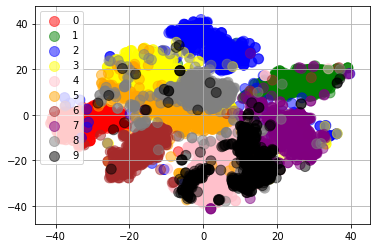

Displaying activation map 1


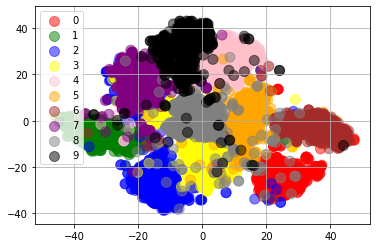

Displaying activation map 2


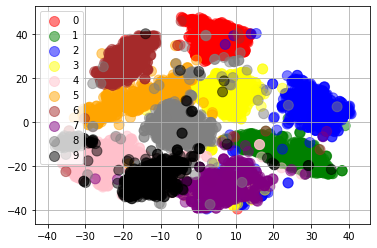

Displaying activation map 3


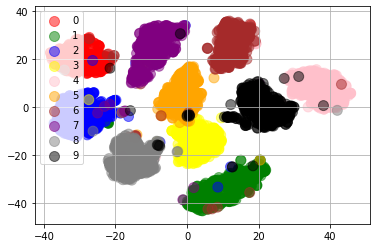

Displaying activation map 4


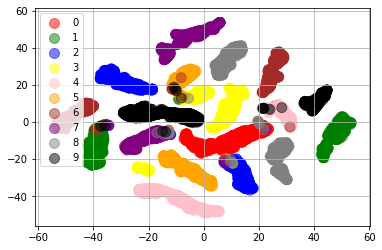

In [22]:
plot_width = 8
plot_height = 200
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Adv']
colors = ['red', 'green', 'blue', 'yellow', 'pink', 'orange', 'brown', 'purple', 'grey', 'black']
classes = np.asarray(y_test_val[0:test_samples])

for layer in range(len(tsne_oputputs)):
        print('Displaying activation map {}'.format(layer))
        
        s = [100 for n in range(len(classes))]
        
        for count in range(11):
            if (count != 10):
                plt.scatter(x=tsne_oputputs[layer][classes == count, 0], y=tsne_oputputs[layer][classes == count, 1], c= colors[count], s=s, marker='o', label=str(count), alpha=0.5)
            else:
                #ax[i].scatter(x=tsne_result[classes == count, 0], y=tsne_result[classes == count, 1], c='black', s=s, marker='+', label='Adv', alpha=0.5)
                break
        lgd = plt.legend(loc=2)
        #plt.axis('off')
        #plt.xticks(np.arange(10))
        #ax[i].text(x=0.5, y=0.9, s='Layer Activation - '+str(i), transform=ax[i].transAxes, size='large', horizontalalignment='center')
        plt.grid(True)
        plt.show()

In [23]:
# Project the adversarial activaitons using the calculated PCA spaces
adv_act_vectors = []
for i, activation_map in enumerate(a_adv):
    print('Projecting adversarial activations for layer: ', i)
    temp = []
    for instance in activation_map:
        temp.append(instance.flatten())
    
    temp = pca_projections[i].transform(np.asarray(temp))
    adv_act_vectors.append(np.asarray(temp))

Projecting adversarial activations for layer:  0
Projecting adversarial activations for layer:  1
Projecting adversarial activations for layer:  2
Projecting adversarial activations for layer:  3
Projecting adversarial activations for layer:  4


In [24]:
# Define a kNN classifier per each layer output
classifiers = []
for i in range(len(act_vectors)):
    print('Fitting kNN classifer for layer - ', str(i))
    classifier = KNeighborsClassifier(n_neighbors = 5)
    classifier.fit(act_vectors[i][0:test_samples], y_test_val[0:test_samples])
    classifiers.append(classifier)

Fitting kNN classifer for layer -  0
Fitting kNN classifer for layer -  1
Fitting kNN classifer for layer -  2
Fitting kNN classifer for layer -  3
Fitting kNN classifer for layer -  4


In [25]:
tags = np.zeros([test_samples, len(classifiers)])
adv_tags = np.zeros([adv_samples, len(classifiers)])

for index in range(test_samples):
    clear_output(wait=True)
    print('Calculating classifications: ', index)
    for layer in range(len(classifiers)):
        tags[index, layer] = classifiers[layer].predict(act_vectors[layer][index].reshape(1, -1))[0]

for index in range(adv_samples):
    clear_output(wait=True)
    print('Claculating adv classification: ', index)
    for layer in range(len(classifiers)):
        adv_tags[index - test_samples, layer] = classifiers[layer].predict(adv_act_vectors[layer][index].reshape(1, -1))[0]

Claculating adv classification:  4999


In [26]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

W1216 12:33:59.679798 140654928152384 font_manager.py:1282] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


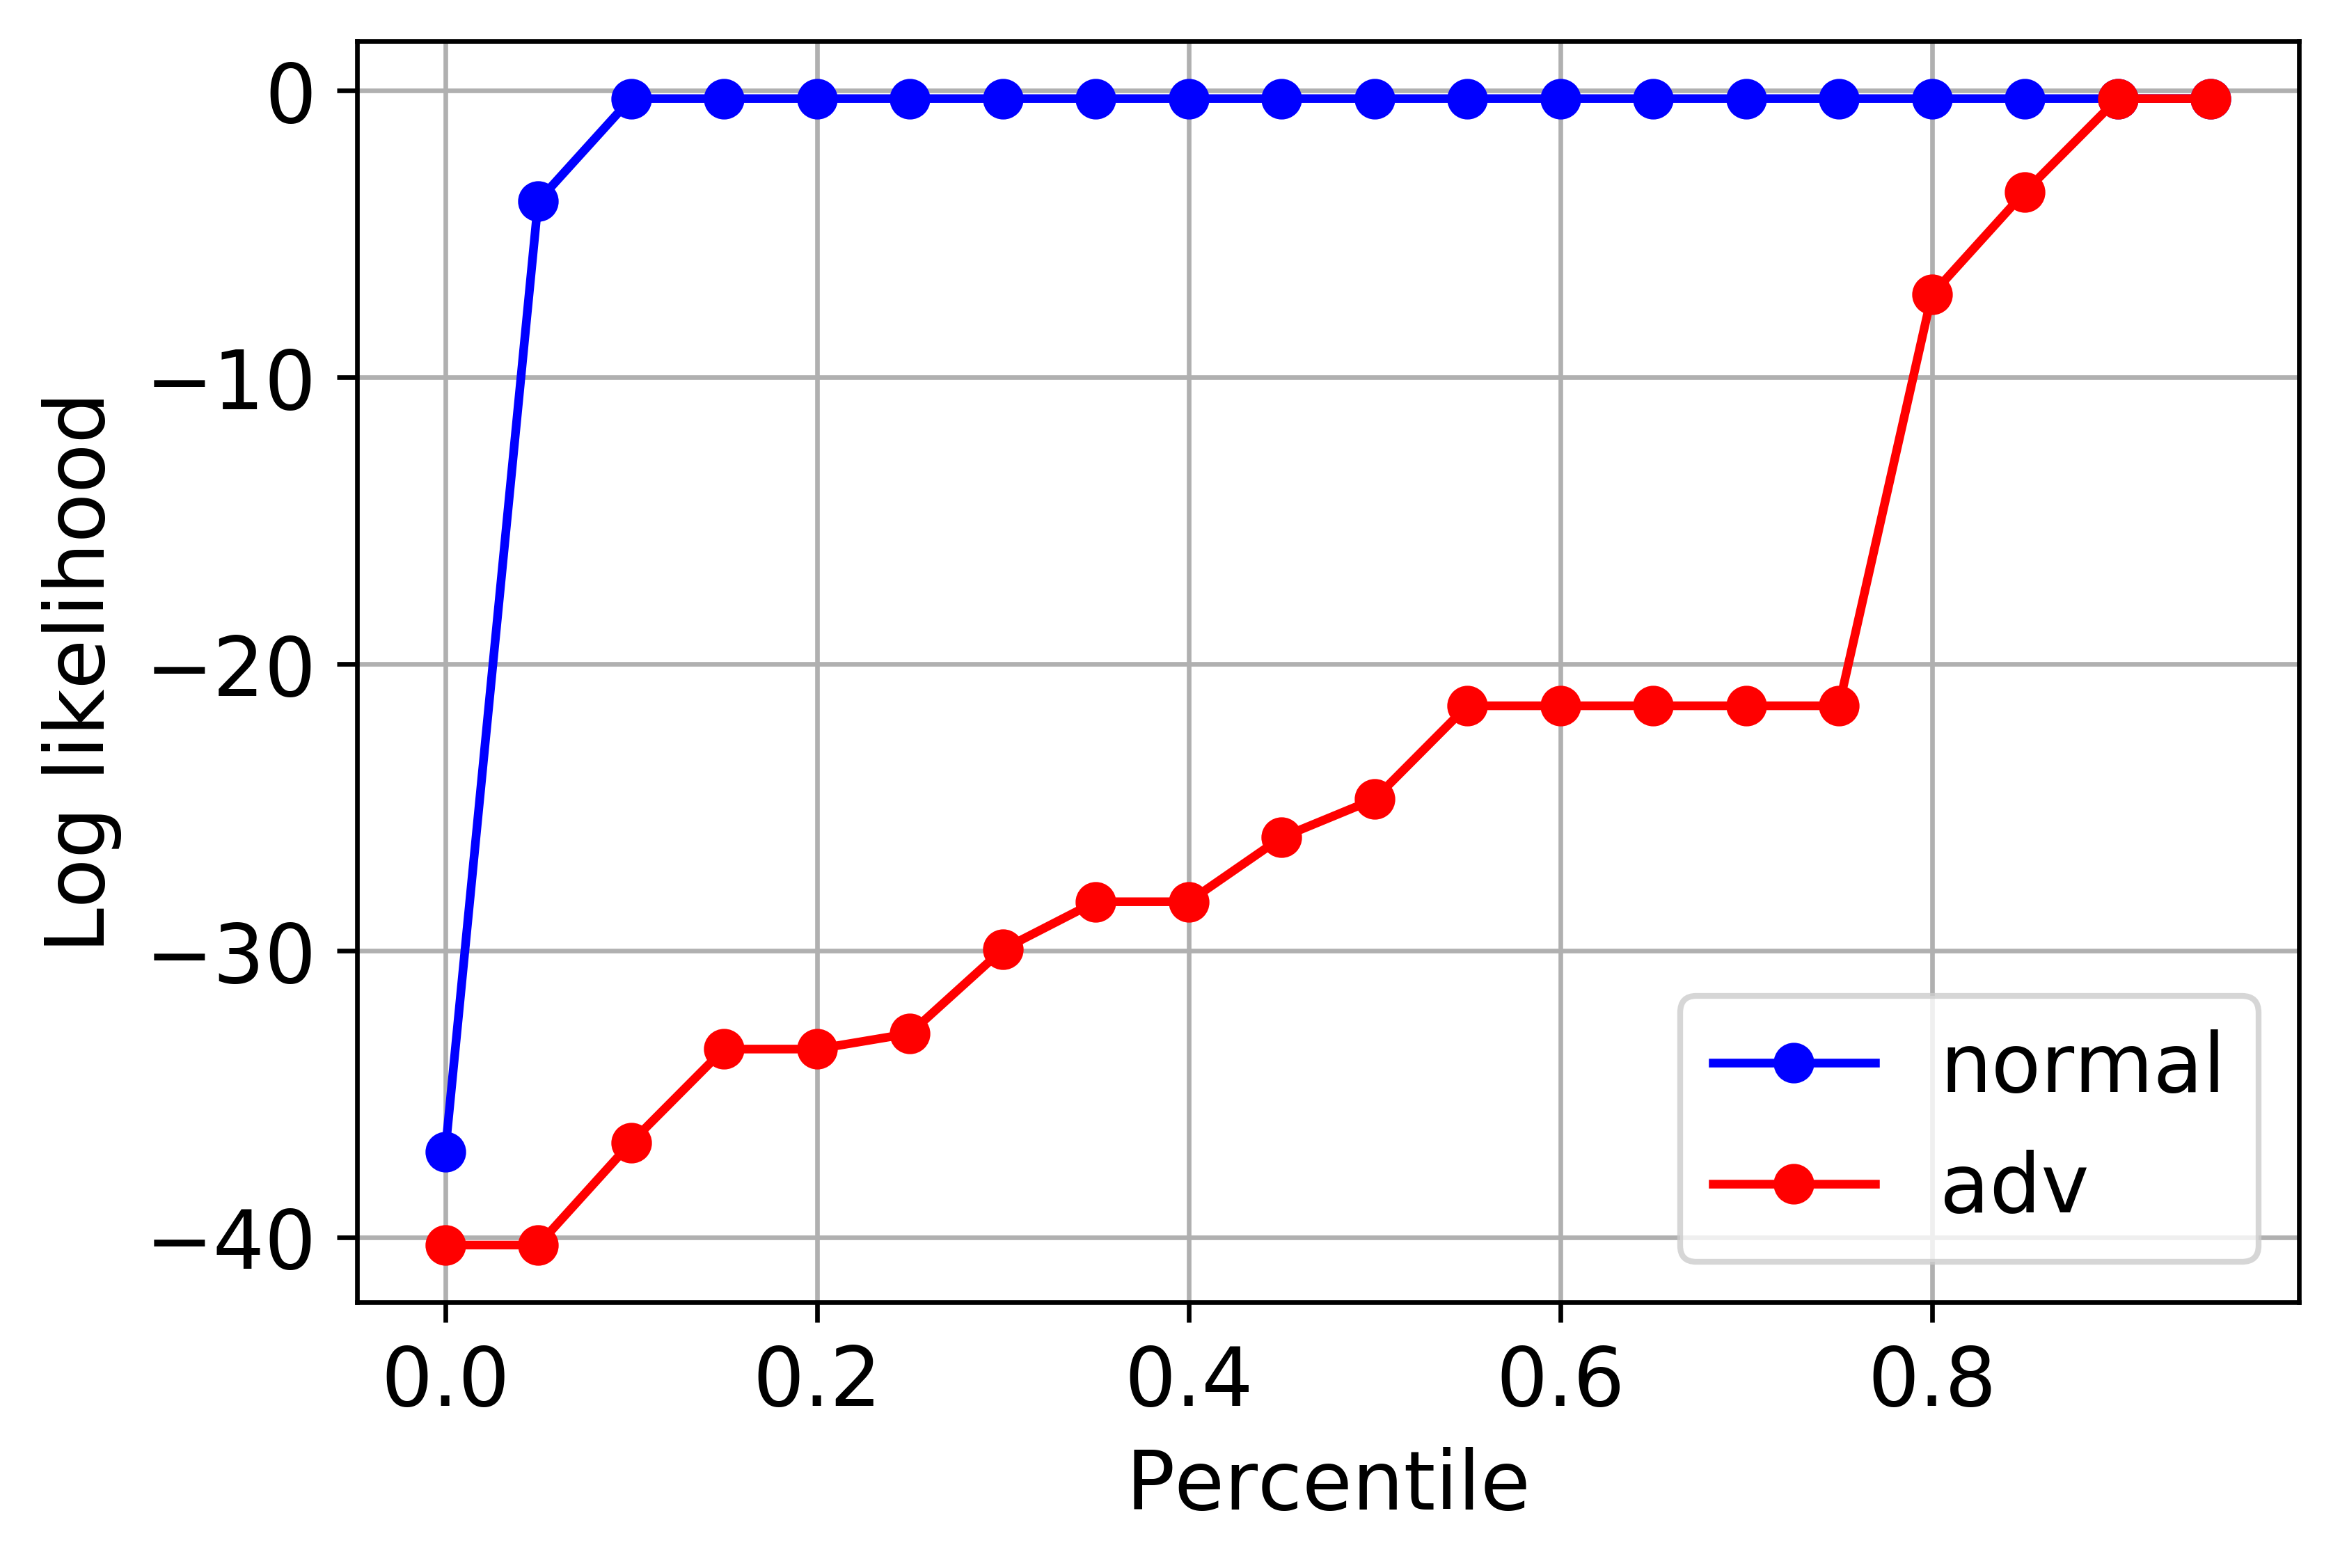

In [27]:
# Plot the log likelihood of the switching sequence of both normal and adversarial examples
(switch_prob, adv_switch_prob, log_probs, adv_log_probs) = plot_log_likelihood(tags, adv_tags, test_samples, adv_samples, start_layer = 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


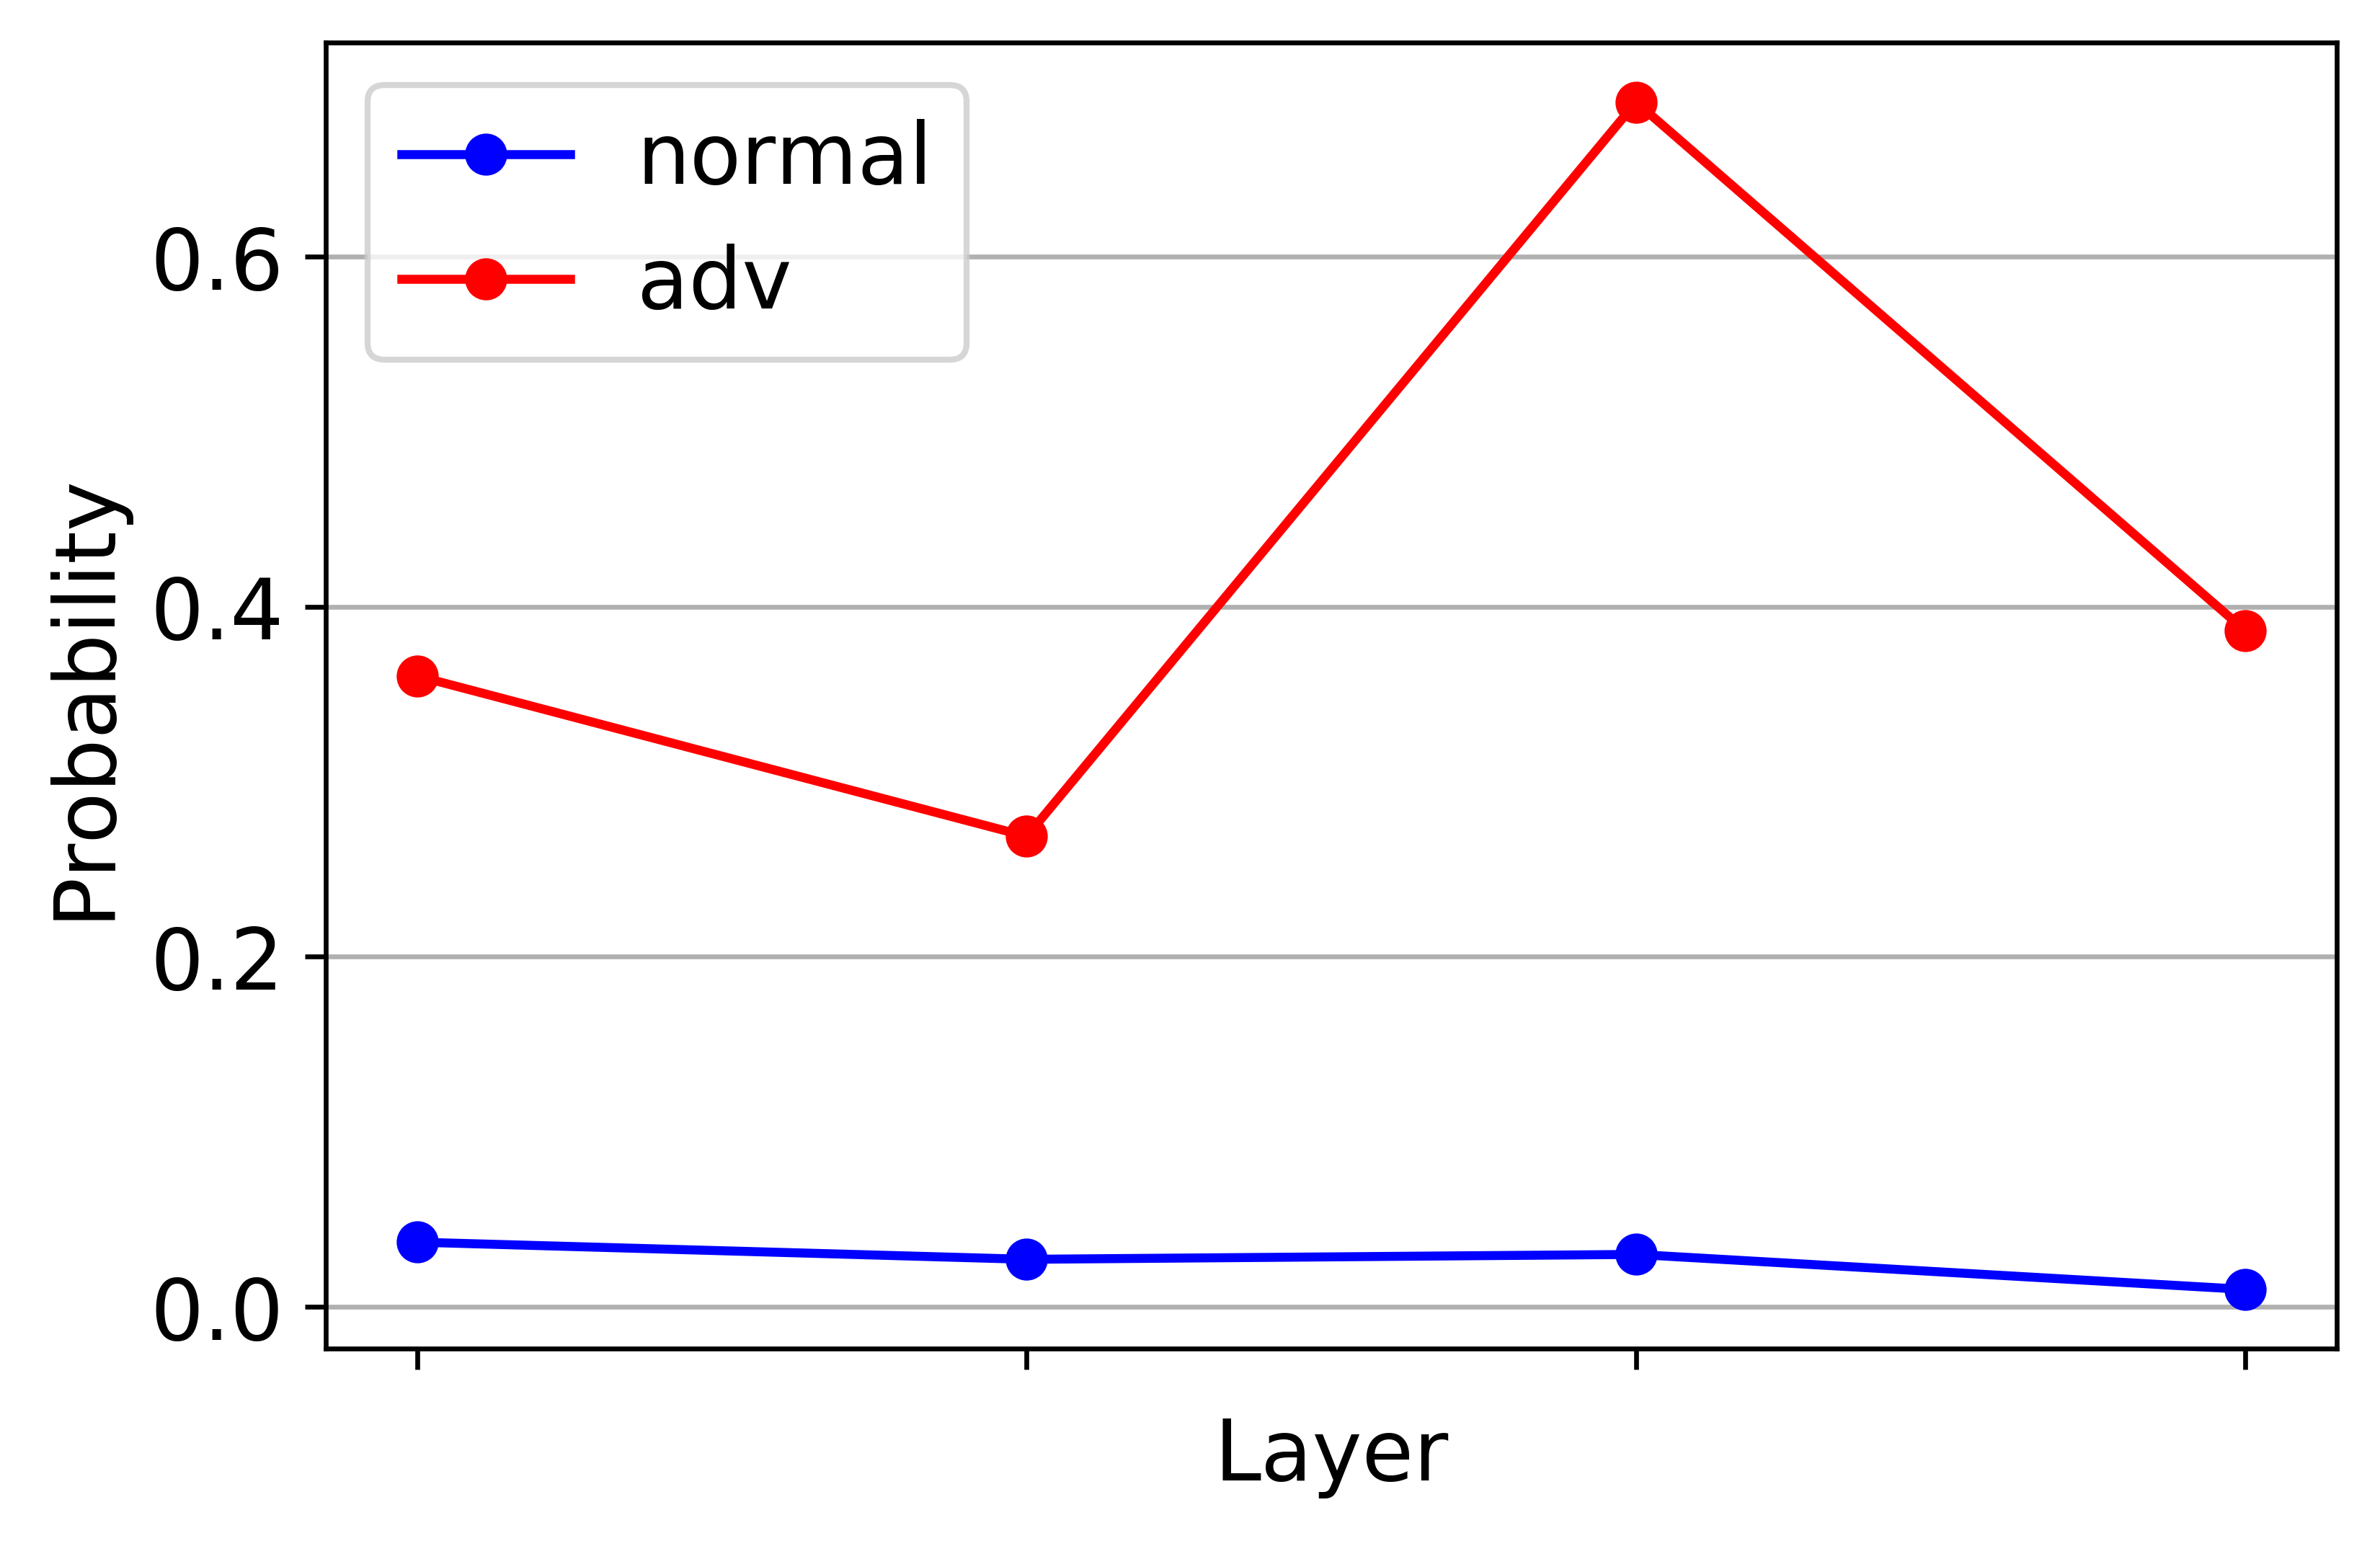

In [28]:
# Plot the a-priori class switching probability for both normal and adversarial examples
plot_apriori_switch_prob(switch_prob, adv_switch_prob)

In [29]:
# Compare correctly classified test instances with all test instances
y_pred = np.argmax(model.predict(x_test), axis=1)
mask = y_pred == y_test_val

x_test_filtered = x_test[0:test_samples][mask[0:test_samples]]
x_adv_filtered = x_test[test_samples:test_samples + adv_samples][mask[test_samples:test_samples + adv_samples]]

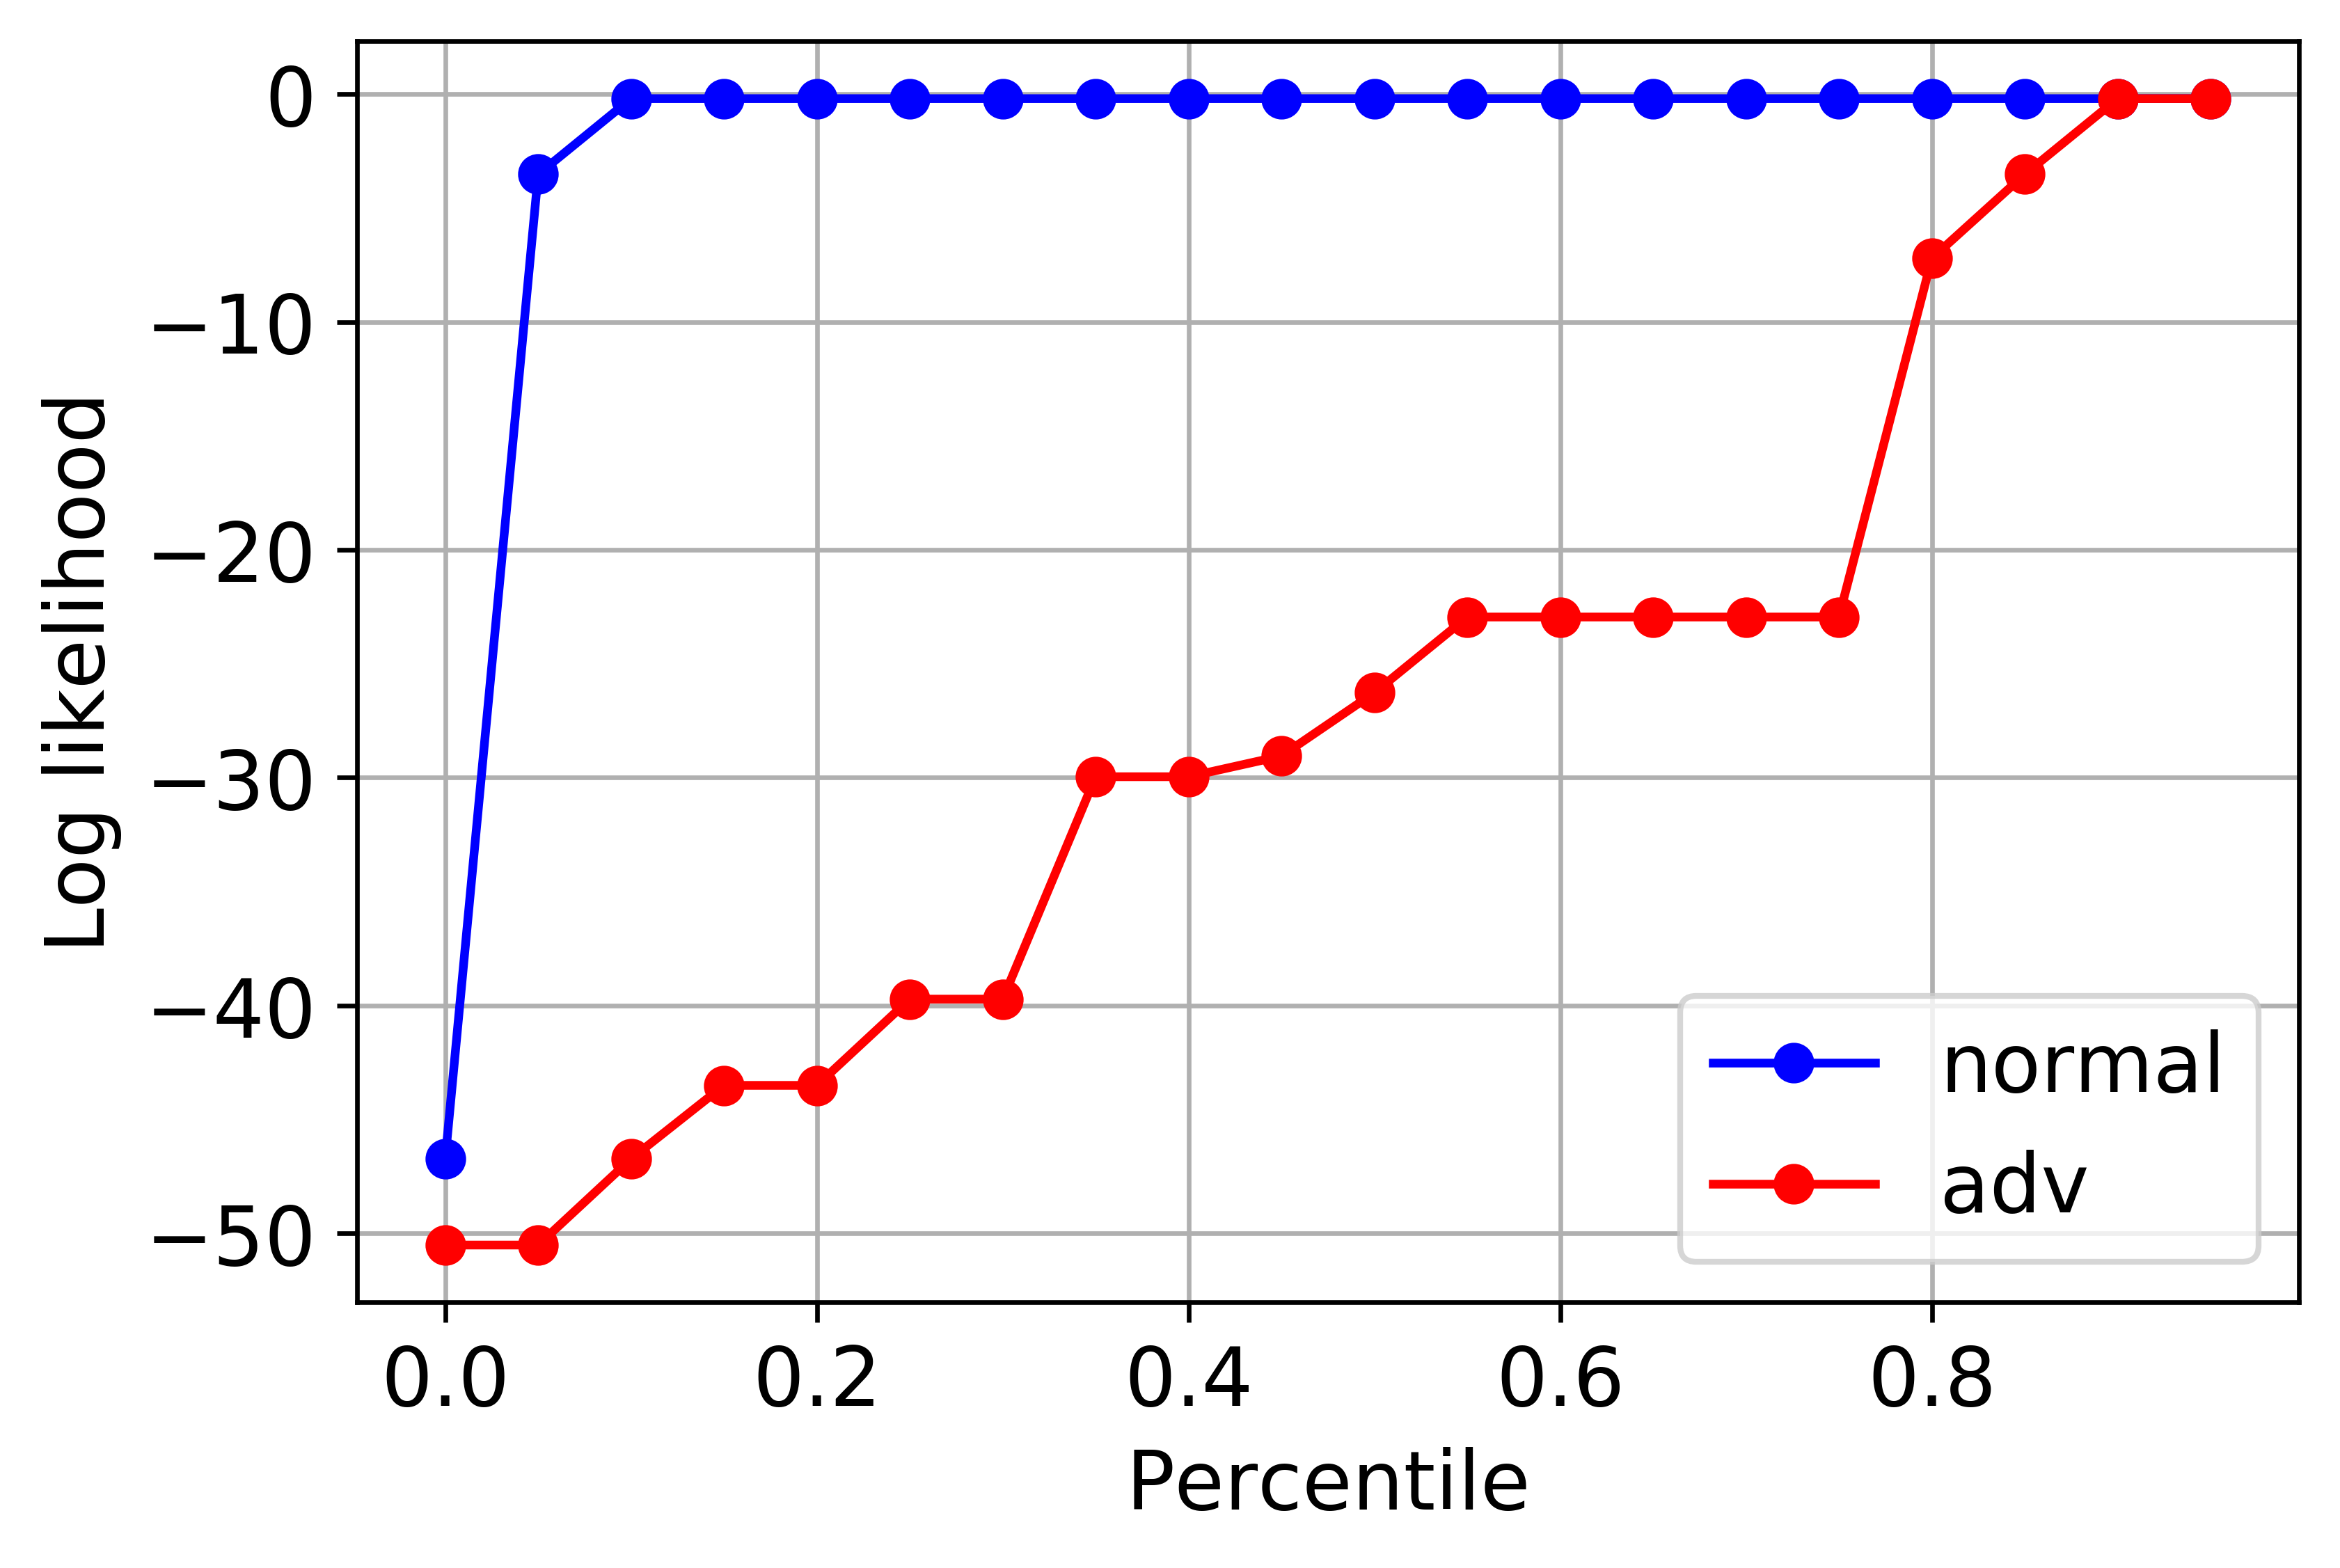

In [30]:
# Plot the log likelihood of the switching sequence of both normal and adversarial examples
filtered_tags = tags[mask[0:test_samples]]
filtered_adv_tags = adv_tags[mask[test_samples:test_samples + adv_samples]]
(switch_prob, adv_switch_prob, filtered_log_probs, filtered_adv_log_probs) = plot_log_likelihood(filtered_tags, 
                                                                                     filtered_adv_tags, 
                                                                                     len(filtered_tags), 
                                                                                     len(filtered_adv_tags),
                                                                                     start_layer = 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


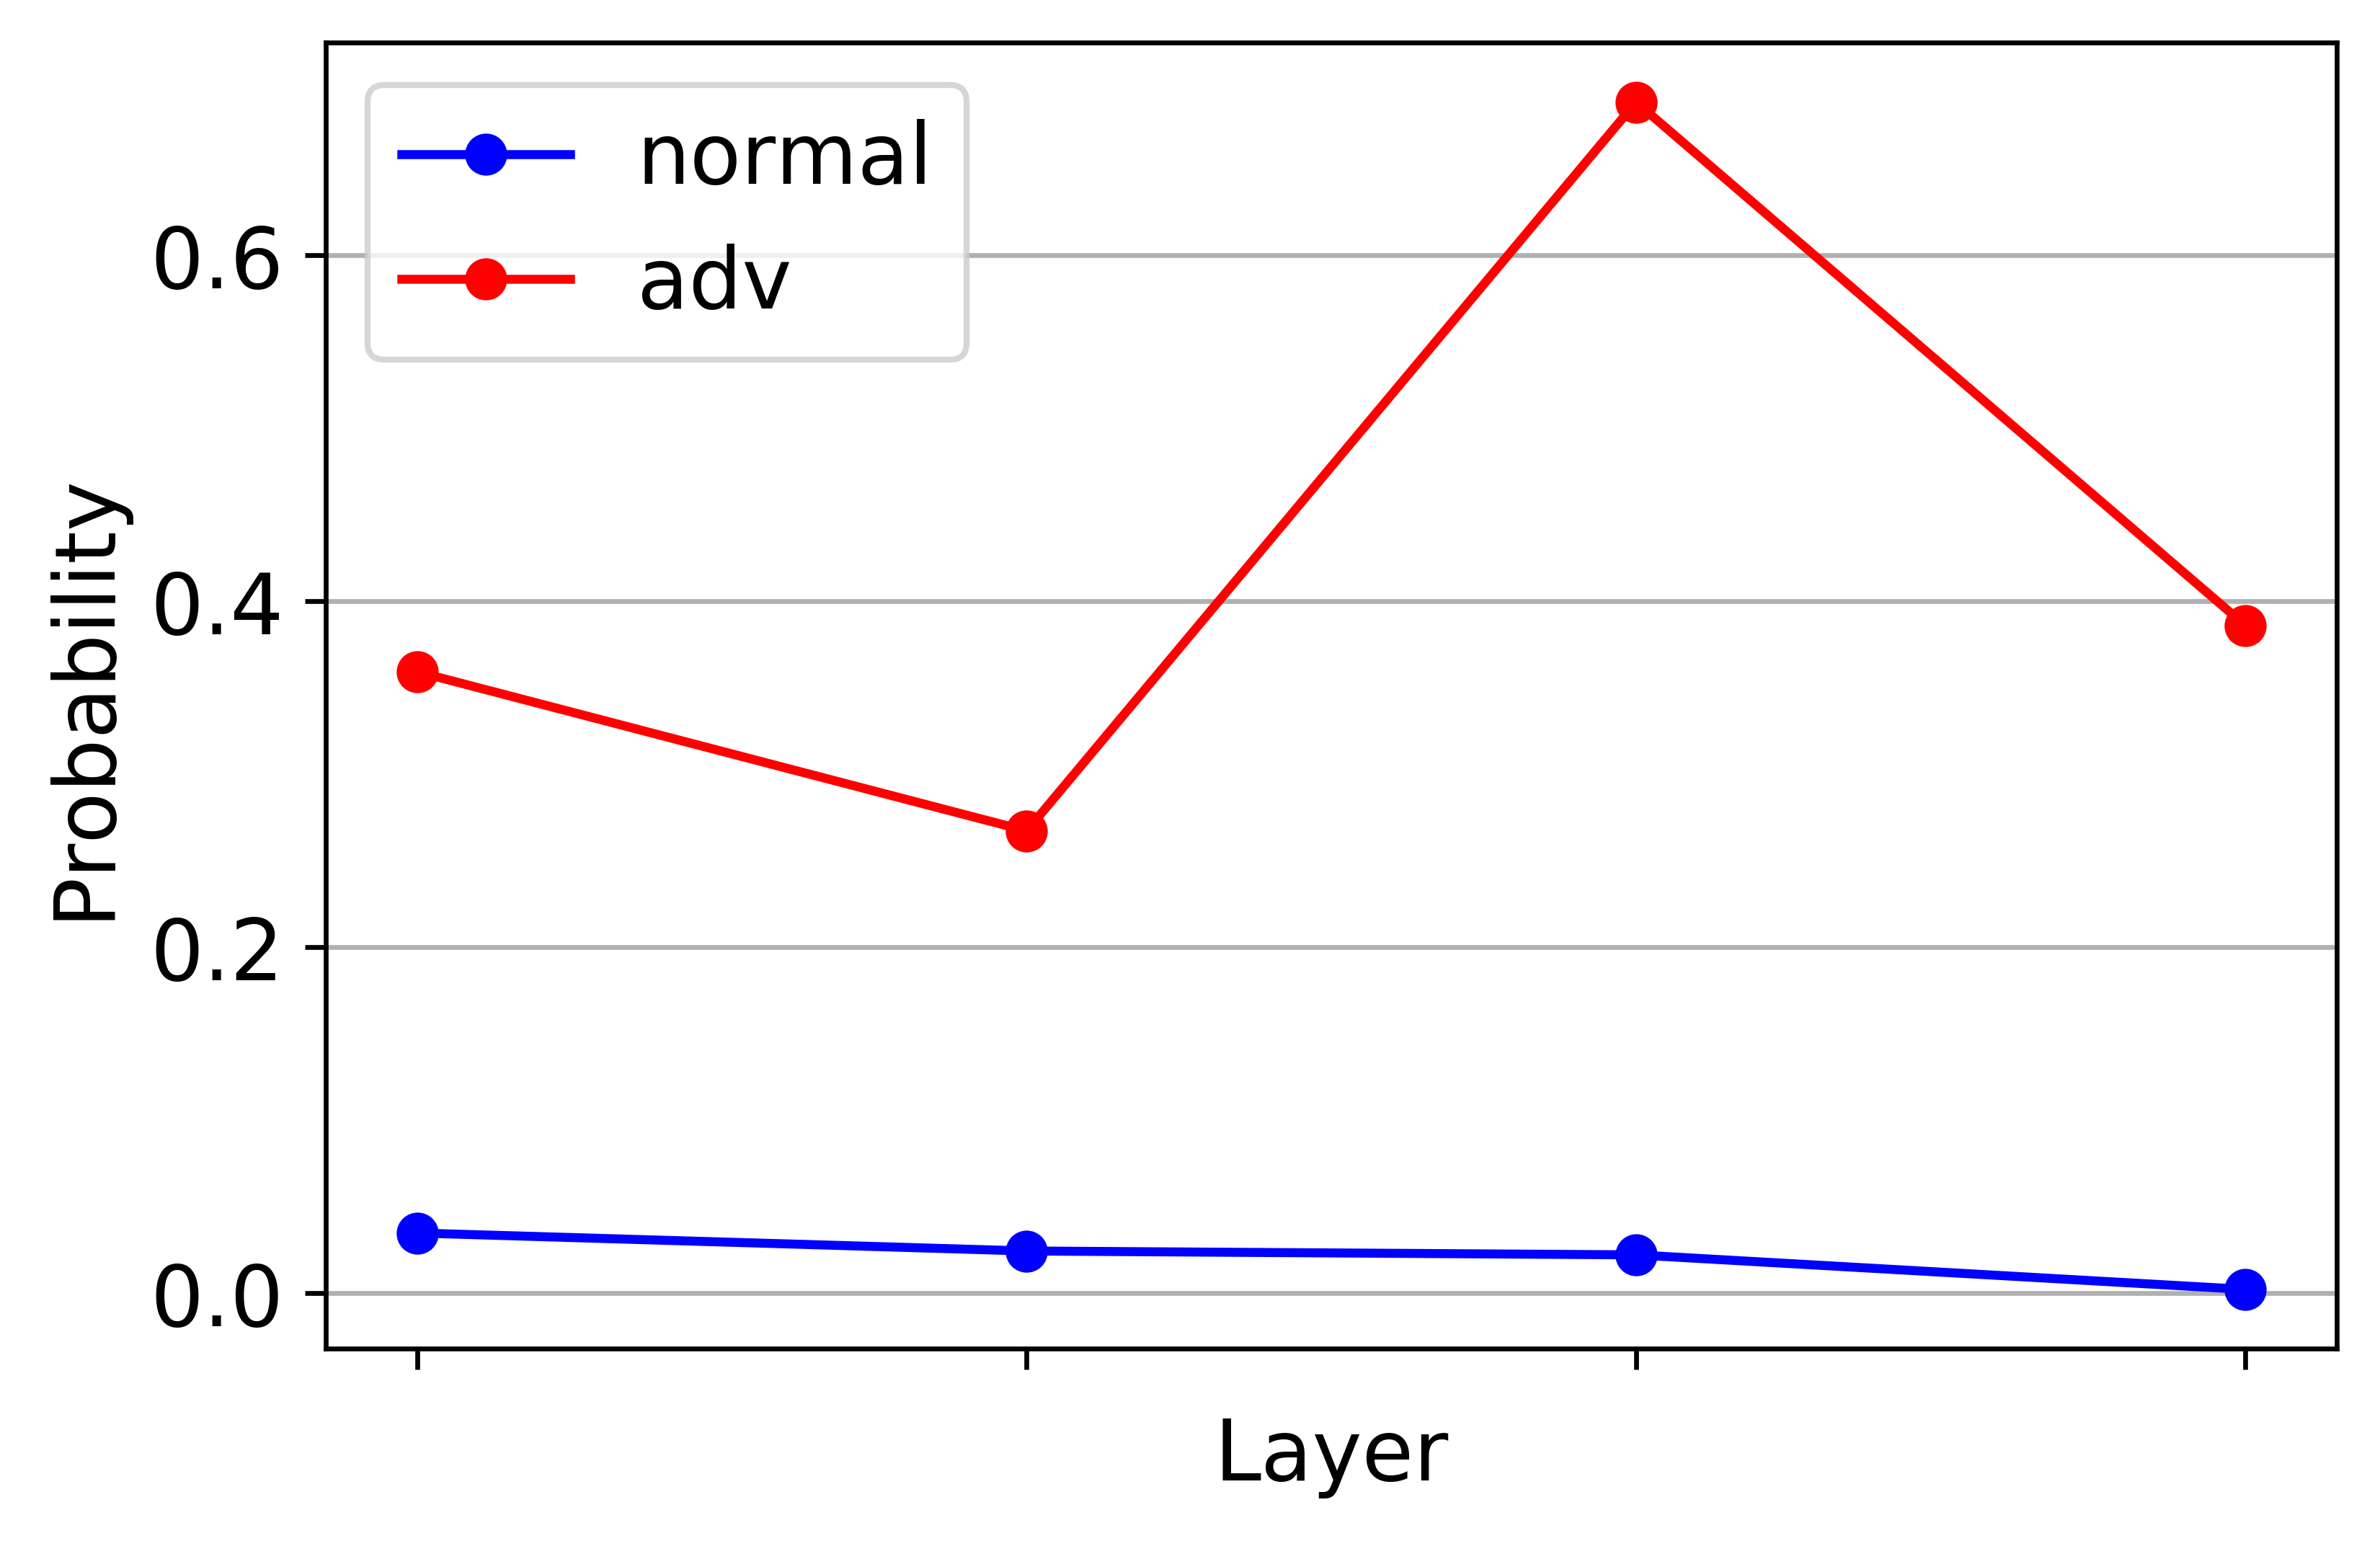

In [31]:
# Plot the a-priori class switching probability for both normal and adversarial examples
plot_apriori_switch_prob(switch_prob, adv_switch_prob)

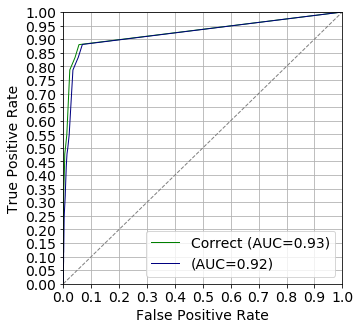

AUC: 0.92


In [32]:
# Filtered AUC curve
samples = -1 * np.concatenate((filtered_log_probs, filtered_adv_log_probs))
labels = np.concatenate((np.array([0,]*len(x_test_filtered)), np.array([1,]*len(x_adv_filtered))))
fpr, tpr, thresholds = metrics.roc_curve(labels, samples, pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (5, 5))
lw = 1
plt.plot(fpr, tpr, color='green', lw=lw, label='Correct (AUC=%.2f)'%auc)

# Add the non-filtered AUC curve
samples = -1 * np.concatenate((log_probs, adv_log_probs))
labels = np.concatenate((np.array([0,]*test_samples), np.array([1,]*adv_samples)))
fpr, tpr, thresholds = metrics.roc_curve(labels, samples, pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy', lw=lw, label='(AUC=%.2f)'%auc)

plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.05, 0.05))
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
#plt.title('Receiver Operating Characteristic Curve')

plt.show()
print('AUC: %.2f'%auc)